# CDK2: evaluations using k conformations
## Data load and preprocessing

In [2]:
%run ./1_Helper_functions.ipynb

In [3]:
%load_ext rpy2.ipython

In [4]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values


R_a = round(y.sum() / len(y), 2)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(6233, 136)
300
Ra = 0.05


## Estimators
### ML Classifiers

In [5]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [7]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [8]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 10, 'learning_rate': 0.1, 
           'gamma': 1, 'colsample_bytree': 0.5, 'alpha': 0.5}
xgb = XGBClassifier(**hyparams)

In [9]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [10]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [11]:
estimators = {**ml_classifiers, **cs_functions}

In [31]:
full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMAX', 'csMEAN', 'csMIN', 'csVOTE']
new_names = dict(zip(estimators.keys(), full_names))

### Evaluation metrics 

In [12]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# Hold-out Validation

In [13]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)


## k-random conformations

### 30 replicas


In [14]:
max_confs = X.shape[1]
k_values = [1, 2, 4, 8, 16, 32, 64, 128, max_confs]
random_state=42

full_results = {}

## Random Selection

In [15]:
%%time

# ************
test_name = 'random'
full_results[test_name] = {}
# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    
    results = n_hold_out_validation_RANDOM_CONFS_SAVE(
                                            filename, n_reps, k, max_confs, 
                                            X, y, metrics, random_state)
        
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = results


File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-random_30_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU times: user 22.9 ms, sys: 5.75 ms, total: 28.7 ms
Wall time: 46 ms


In [16]:
df_random = get_group_stats(full_results[test_name], metric_name='roc_auc', indexes_values=k_values)

R[write to console]: ── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Registering fonts with R

R[write to console]: ------------------------------------------------------------------------------

R[write to console]: You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

R[write to console]: -------------------------------------------------------------------------

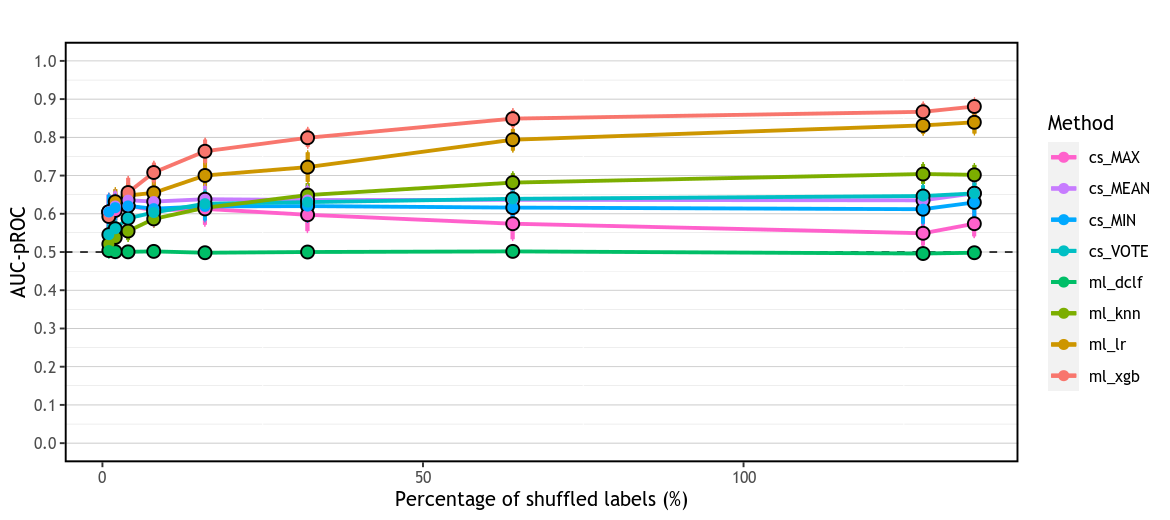

In [17]:
%%R -i df_random  -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(8)

plot_lines(df_random, cbbPalette, y_min=0.0, y_max=1., 
               y_label='AUC-pROC', base_h_line=0.5, switch_x=FALSE) 

## REF preselected => XGB

In [18]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'XGB_tree'
split = 'random'
filename = f'../../../FXa/ANALISIS/6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

/home/ricci/miniconda3/envs/mds/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RFECV from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [19]:
%%time

# ************
test_name = 'RFExgb'
full_results[test_name] = {}
# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-RFExgb_30_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU times: user 37.7 ms, sys: 20.1 ms, total: 57.9 ms
Wall time: 55.7 ms


## REF preselected => RandomForest (duplicates dropped)

In [48]:
# Open RFE_estimator
dataset = 'MERGED'
model_name = 'RandomForest'
split = 'random'
filename = f'../../../FXa/ANALISIS/6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': X_merged_dksc.columns, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')

df_ranks_dropped = df_ranks.drop_duplicates('rfe_ranking')

In [49]:
%%time

# ************
test_name = 'RFE-Drop-Rforest'
full_results[test_name] = {}
# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    if k < df_ranks.shape[0]:
        conformations = df_ranks_dropped.index[:k]
    else:
        conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File saved: ./cachedir/k_confs/k-confs-RFE-Drop-Rforest_30_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU times: user 1h 26mi

## Best conformations (single AUC-ROC score)

In [22]:
# Import the conformations features table
file=f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl'
with open(file, 'rb') as f:
    df_feat = pickle.load(f)

# Reset index to access each conformation per inx position
df_feat = df_feat.reset_index()

In [23]:
%%time

# ************
test_name = 'singConfAUC'
full_results[test_name] = {}

df_ranks = df_feat.sort_values('AUC-ROC', ascending=False)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-singConfAUC_30_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU times: user 40.1 ms, sys: 19.9 ms, total: 60 ms
Wall ti

## Conformations from bigger inhibitors

In [24]:
%%time

# ************
test_name = 'bigLigMW'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Inhib. MW', ascending=False)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-bigLigMW_30_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU times: user 43.2 ms, sys: 12.7 ms, total: 55.9 ms
Wall time: 52.7 ms


## Conformations from non or smaller inhibitors

In [25]:
%%time

# ************
test_name = 'smallLigMW'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Inhib. MW', ascending=True)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-smallLigMW_30_reps_fxa_nConfs-136
Evaluation with k=136 finished.
CPU times: user 39.1 ms, sys: 12.3 ms, total: 51.4 ms
Wall time: 49.

## Conformations with largest pocket volume

In [26]:
%time

# ************
test_name = 'bigPkVolume'
full_results[test_name] = {}
df_ranks = df_feat.sort_values('Pk. Volume', ascending=False)

# ************
n_reps = 30
evaluation_name = f'k-confs-{test_name}_{n_reps}_reps'

for k in k_values:
    # Name the output file
    filename = f'./cachedir/k_confs/{evaluation_name}_{protein_name}_nConfs-{k}'
    # Get the conformations using the selector
    conformations = df_ranks.index[:k]
    X_sub = X[:, conformations]
    # Do the analysis
    result = n_hold_out_validation_SAVE(
                 filename=filename, 
                 estimators=estimators, 
                 X=X_sub, y=y, metrics=metrics, 
                 n_reps=n_reps, random_state=random_state
            )
    print(f'Evaluation with k={k} finished.')
    # *******************************
    full_results[test_name][f'k_{k}'] = result


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-1
Evaluation with k=1 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-2
Evaluation with k=2 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-4
Evaluation with k=4 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-8
Evaluation with k=8 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-16
Evaluation with k=16 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-32
Evaluation with k=32 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-64
Evaluation with k=64 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-128
Evaluation with k=128 finished.
File loaded: ./cachedir/k_confs/k-confs-bigPkVolume_30_reps_fxa_nConfs-136
Evaluation with k=136 f

# Plot Results

In [50]:
full_results.keys()

dict_keys(['random', 'RFExgb', 'singConfAUC', 'bigLigMW', 'smallLigMW', 'bigPkVolume', 'RFE-Drop-Rforest'])

In [51]:
# Faormat the results into a untidy dataframe
dict_df_results = {test_name: get_group_stats( df, 
                                   metric_name='roc_auc', 
                                   indexes_values=k_values).replace(new_names)
                   for test_name, df in full_results.items()}

In [52]:
df_xgb = pd.concat(dict_df_results.values(), keys=dict_df_results.keys())
df_xgb = df_xgb.query('method == "XGB"').reset_index().drop(['method', 'level_1'], axis=1).rename(columns={'level_0': 'method'})

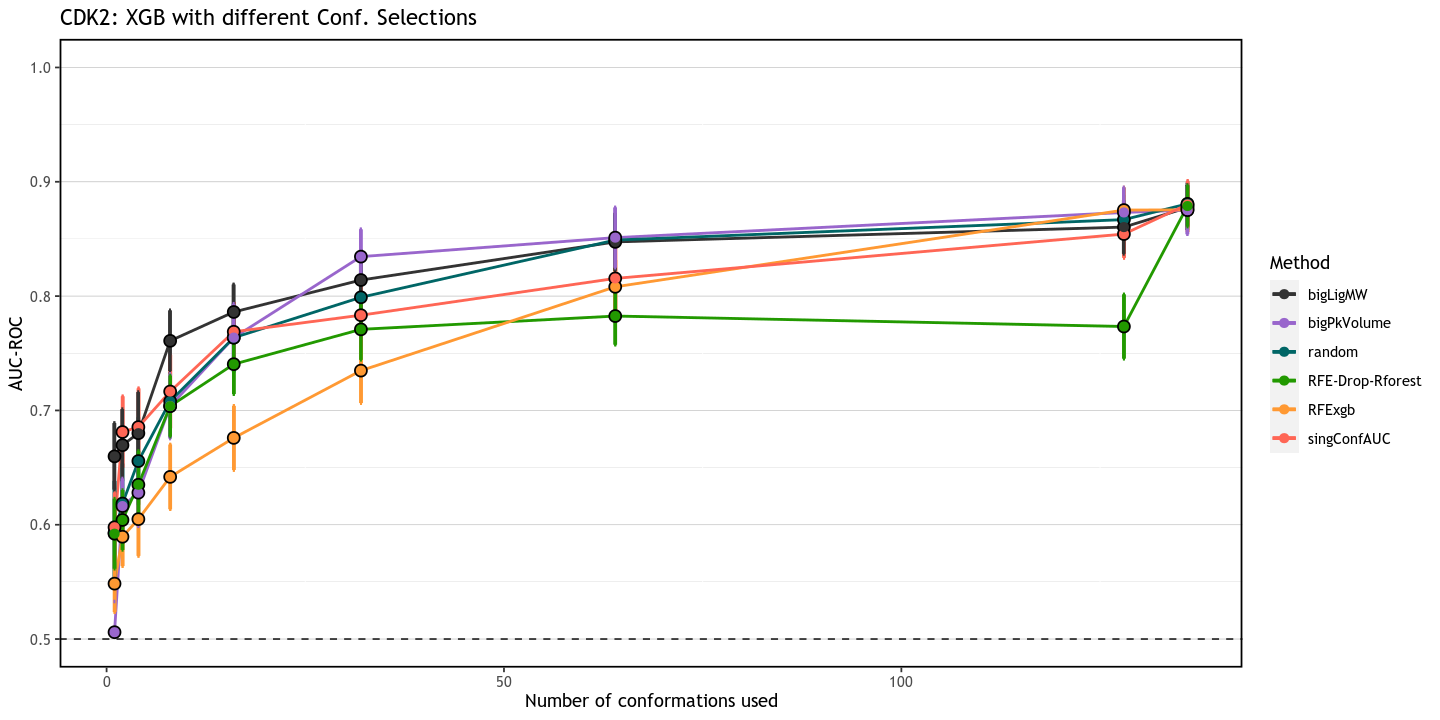

In [54]:
%%R -i full_names -i df_xgb -w 12 -h 6 --units in -r 120
library(wesanderson)

source('./plotSwarmBox.R')
metric_name <- 'AUC-ROC'

df <- df_xgb %>%
    filter(!method %in% c('smallLigMW', 'coorrelatedFeatures')) 
cbbPalette <- c('#FF6655', '#FF9933', '#229900',  '#006666', '#9966CC', '#333333') 

plot_lines(df, cbbPalette, y_min=0.5, y_max=1., line_size=0.8, title='CDK2: XGB with different Conf. Selections',
               y_label=metric_name, base_h_line=0.5, switch_x=FALSE, 
               x_label="Number of conformations used") 

R[write to console]: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



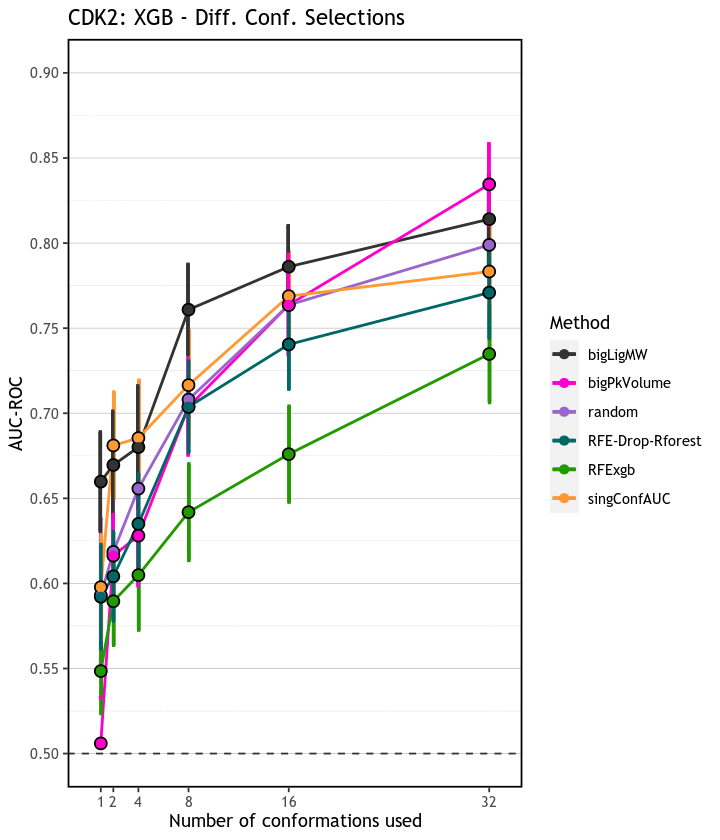

In [55]:
%%R -i full_names -i df_xgb  -w 6 -h 7 --units in -r 120

source('./plotSwarmBox.R')

title='CDK2: XGB - Diff. Conf. Selections'
methods <- c('XGB', 'DummyClf', 'csMEAN')
max_confs <- 33

df <- df_xgb %>%
    filter(!method %in% c('smallLigMW', 'coorrelatedFeatures')) 
cbbPalette <- c('#FF6655', '#FF9933', '#229900',  '#006666', '#9966CC', '#FF00CC', '#333333') 

x_ticks <- c(1,2,4,8,16,32)
plot_lines(df, cbbPalette, y_min=0.5, y_max=1., line_size=0.8, title=title,
               y_label='AUC-ROC', base_h_line=0.5, switch_x=FALSE, error_dodge=0.1,
               x_label="Number of conformations used") +
               scale_x_continuous(breaks = x_ticks, limits=c(0, max_confs)) +
               scale_y_continuous(breaks = seq(0.5, 1, by = .05), limits=c(0.5, .9))